In [389]:
%matplotlib inline

In [452]:
#Возможно понадобятся графики, оптимизирую заранее
sns.set(font_scale =1, style ="whitegrid", rc ={'figure.figsize':(20,7)})

In [2]:
#Выгружаю нужные библиотеки
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import datetime
from operator import attrgetter
from datetime import timedelta

In [3]:
#Считываю нужные по заданию датафреймы
customers = pd.read_csv('/Users/sergejegolaev/Work/olist_customers_dataset.csv')
orders = pd.read_csv('/Users/sergejegolaev/Work/olist_orders_dataset.csv')
order_item = pd.read_csv('/Users/sergejegolaev/Work/olist_order_items_dataset.csv')

Посмотрим на данные в каждом датафрейме

In [4]:
customers.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP


In [5]:
customers.shape

(99441, 5)

Сколько всего уникальных данных в каждом из столбцов

In [6]:
customers.nunique()

customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64

In [7]:
customers.describe()

,customer_zip_code_prefix
count,99441.000000
mean,35137.474583
std,29797.938996
min,1003.000000
25%,11347.000000
50%,24416.000000
75%,58900.000000
max,99990.000000


In [8]:
orders.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00


In [9]:
orders.nunique()

order_id                         99441
customer_id                      99441
order_status                         8
order_purchase_timestamp         98875
order_approved_at                90733
order_delivered_carrier_date     81018
order_delivered_customer_date    95664
order_estimated_delivery_date      459
dtype: int64

In [10]:
#посмотрим распределение по статусам заказов
orders \
.groupby('order_status', as_index=False) \
.agg({'customer_id':'count'})

,order_status,customer_id
0,approved,2
1,canceled,625
2,created,5
3,delivered,96478
4,invoiced,314
5,processing,301
6,shipped,1107
7,unavailable,609


In [11]:
# Посмотрим на заполнение времени по разным этапам заказов. 
# Исходя из распределения по статусам, некоторые значения в столбцах со временем должны быть не заполнены
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Посмотрим на пустые значения в колонке "order_approved_at" чтобы понять по какой 
причине часть заказов была не оплачена

In [12]:
orders['order_approved_at'] = orders['order_approved_at'].fillna (0)

In [13]:
orders \
.query('order_approved_at==0') \
.groupby('order_status', as_index=False) \
.agg({'customer_id':'count'})

,order_status,customer_id
0,canceled,141
1,created,5
2,delivered,14


Получили 14 заказов которые уже доставлены но по которым нет даты получения оплаты. Предположим сбой системы оплаты. Возможно данные пригодятся позже, так же информацию стоит передать продакт-менеджеру Василию

In [14]:
# Посмотрим так же на заказы со статусом "недоступен(unavailable)" чтобы понять на каком этапе происходит отмена
# заказа
orders \
.query('order_status=="unavailable"').isna().sum()

order_id                           0
customer_id                        0
order_status                       0
order_purchase_timestamp           0
order_approved_at                  0
order_delivered_carrier_date     609
order_delivered_customer_date    609
order_estimated_delivery_date      0
dtype: int64

Исходя из того что по всем заказам со статусом "недоступен" не заполнены даты передачи товара перевозчику и дата доставки, заказ отменяется продавцом и он приобретает статус "недоступен"

In [15]:
order_item.head(2)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93


In [16]:
order_item.order_id.nunique()

98666

Значений меньше чем в других таблицах. Попробую понять какие заказы не попали в таблицу с товарными позициями и почему(посмотрю статусы)

In [17]:
orders.merge(order_item.groupby('order_id').agg({'order_item_id':'sum'}), how='left', on='order_id') \
.fillna(0)\
.query('order_item_id==0')\
.groupby('order_status', as_index=False) \
.agg({'customer_id':'count'})

,order_status,customer_id
0,canceled,164
1,created,5
2,invoiced,2
3,shipped,1
4,unavailable,603


Два заказа со статусом "выставлен счет" не попали в табличку с данными по заказу, так же не попал один доставленный заказ. Эту информацию так же стоит передать продакт-менеджеру Василию

In [18]:
orders_with_item = orders.merge(order_item.groupby('order_id').agg({'order_item_id':'sum'}), how='left', on='order_id') \
.fillna(0)
orders_with_item.loc[((orders_with_item['order_item_id'] == 0) &(orders_with_item['order_status' ] == 'shipped'))]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id
23254,a68ce1686d536ca72bd2dadc4b8671e5,d7bed5fac093a4136216072abaf599d5,shipped,2016-10-05 01:47:40,2016-10-07 03:11:22,2016-11-07 16:37:37,0,2016-12-01 00:00:00,0.0


Собрал информацию по этому заказу

# 1. Сколько у нас пользователей, которые совершили покупку только один раз?

 
Судя по распределению статусов, предполагаю что покупкой необходимо считать статусы "processing", "shipped", "delivered". Остальные статусы покупкой не являются, клиент может просто добавлять товары в корзину, либо Есть сомнения по поводу статуса "invoiced", проверю есть ли подтверждение оплат для заказов с таким статусом. 

Чтобы посчитать единичные заказы по статусам, необходимо взять данные из двух табличек "orders" и "customers", в одной есть необходимое сочетание - уникального и позаказного идентификатора, а во второй сочетание позаказного идентификатора со статусом. Отсотрируем полученый датафрейм по колонке с ИД пользователя и по статусам и посчитаем колличество позаказных ИД у каждого из них. Далее отсортируем покупателей с одой покупкой и посчитаем количество строк командой "len"

In [19]:
orders \
.loc[(orders_with_item['order_status' ] == 'invoiced')] \
.isna().sum()

order_id                           0
customer_id                        0
order_status                       0
order_purchase_timestamp           0
order_approved_at                  0
order_delivered_carrier_date     314
order_delivered_customer_date    314
order_estimated_delivery_date      0
dtype: int64

Для всех заказов с подобным статусом оплата подтверждена. Есть вероятность отмены подобного заказа со стороны продавца после приема оплаты но так как этих данных у нас нет, поэтому оплаченый заказ буду так же учитывать

In [20]:
len(customers.merge(orders) \
.query("order_status in ('processing', 'shipped', 'delivered', 'invoiced')")
.groupby('customer_unique_id') \
.agg({'customer_id':'count'}) \
.query('customer_id==1'))

92097

# 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

Недоставленные заказы видны в таблице "orders", с отсутствующей датой доставки. Из анализа таблицы таких заказов 2965. Посмотрю на полученые данные и на статусы этих заказов

In [21]:
orders \
.fillna(0) \
.query('order_delivered_customer_date==0') \
.groupby('order_status', as_index=False) \
.agg({'customer_id':'count'})

,order_status,customer_id
0,approved,2
1,canceled,619
2,created,5
3,delivered,8
4,invoiced,314
5,processing,301
6,shipped,1107
7,unavailable,609


Часть подобных заказов уже доставлены. Информацию необходимо передать Василию, и исключить заказы со статусом "delivered" из данных для распределения недоставленных заказов по месяцам 

In [22]:
no_delivered_orders = orders \
.fillna(0) \
.query('order_delivered_customer_date==0') \
.query('order_status !="delivered"')

In [23]:
#Проверю типы данных 
no_delivered_orders.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

In [24]:
#Для приведения даты создания к месяцам, изменю тип данных на "Дата"
no_delivered_orders['order_purchase_timestamp'] = pd.to_datetime(no_delivered_orders['order_purchase_timestamp'])

In [25]:
# Приведу дату создания заказа к месяцу, т.к. необходимо распределение по месяцам в среднем
no_delivered_orders['order_purchase_timestamp'] = no_delivered_orders['order_purchase_timestamp'].dt.strftime('%Y-%m')

In [26]:
#Cгруппирую по мечсяцам и статусам заказов чтобы понять сколько каждый месяц не доставляется заказов 
#и по каким причинам. Далее сгруппирую по статусам и посчитаю среднемесячное количество не доаставленных по разным
#причинам заказов. Для удобства восприятия округлим до целых чисел
no_delivered_orders \
.groupby(['order_purchase_timestamp','order_status'], as_index=False) \
.agg({'customer_id':'count'}) \
.groupby('order_status', as_index=False) \
.agg({'customer_id':'mean'}) \
.round(0)

,order_status,customer_id
0,approved,1.0
1,canceled,26.0
2,created,2.0
3,invoiced,15.0
4,processing,16.0
5,shipped,48.0
6,unavailable,29.0


# 3. По каждому товару определить, в какой день недели товар чаще всего покупается. (5 баллов)

Так как данные по ИД товара и дате заказа хранятся в разных таблицах, и покупка это заказы с определенных статусом, приведем данные к нужному виду

In [27]:
day_by_week=order_item.merge(orders) \
.query("order_status in ('processing', 'shipped', 'delivered', 'invoiced')")

In [28]:
#Посмотрим тип данных
day_by_week.dtypes

order_id                          object
order_item_id                      int64
product_id                        object
seller_id                         object
shipping_limit_date               object
price                            float64
freight_value                    float64
customer_id                       object
order_status                      object
order_purchase_timestamp          object
order_approved_at                 object
order_delivered_carrier_date      object
order_delivered_customer_date     object
order_estimated_delivery_date     object
dtype: object

In [29]:
#Для приведения даты создания к дням недели, изменю тип данных на "Дата"
day_by_week['order_purchase_timestamp'] = pd.to_datetime(day_by_week['order_purchase_timestamp'])

In [30]:
# Приведу дату создания заказа к дню недели, т.к. необходимо узнать по каждому товару в какой день недели 
#покупается чаще всего
day_by_week['order_purchase_timestamp'] = day_by_week['order_purchase_timestamp'].dt.strftime('%a')

In [31]:
#Сделаю сортировку по товару и дню недели и посчитаю количество покупок
max_day_by_week = day_by_week \
.groupby(['product_id','order_purchase_timestamp'], as_index=False) \
.agg({'seller_id':'count'}) \
.sort_values('seller_id', ascending=False)

In [32]:
#Проранжирую сумму покупок по дням недели по позиции методом "rank"
max_day_by_week['rating'] = max_day_by_week.groupby('product_id')['seller_id'] \
.rank(method="first", ascending=False) 

In [35]:
#Отсортирую только максимальные результаты по методу, оставлю только нужные колонки и сброшу индекс для 
#простоты восприятия
max_day_by_week = max_day_by_week \
.query('rating == 1') \
.sort_values('seller_id',ascending=False) \
.reset_index() \
[["product_id", "order_purchase_timestamp"]]
max_day_by_week

,product_id,order_purchase_timestamp
0,422879e10f46682990de24d770e7f83d,Wed
1,99a4788cb24856965c36a24e339b6058,Mon
2,aca2eb7d00ea1a7b8ebd4e68314663af,Thu
3,53b36df67ebb7c41585e8d54d6772e08,Tue
4,368c6c730842d78016ad823897a372db,Fri
...,...,...
32722,bf3024b979e260a941c418cc5771fff2,Fri
32723,bf2f8efdd119b43056e1355c46119f04,Sun
32724,bf2f8d918c34551d0bc8861f3779953e,Fri
32725,bf2ce842e3094204d338854ad96ba5ae,Mon


# 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 

In [36]:
#Так как нужные для ответа данные хранятся в разных таблицах, соберу в одну

custom_ord_item = customers.merge(orders.merge(order_item))

In [37]:
#Для приведения даты создания к дням недели, изменю тип данных на "Дата"
custom_ord_item['order_purchase_timestamp'] = pd.to_datetime(custom_ord_item['order_purchase_timestamp'])

In [38]:
# Интересуют покупки за неделю в месяц. Приведу дату к нужному формату
custom_ord_item.order_purchase_timestamp = custom_ord_item.order_purchase_timestamp.dt.strftime('%Y-%m')

In [39]:
#Отсортирую данные по статусам демонстрирующим покупку(из предыдущих пунктов), сгруппирую по пользователю и дате
#покупки, посчитаю количество покупок в месяц
custom_ord_items = custom_ord_item \
.query("order_status in ('processing', 'shipped', 'delivered', 'invoiced')")\
.groupby(["customer_unique_id", "order_purchase_timestamp"], as_index=False) \
.agg({"customer_state":"count"})

In [604]:
#custom_ord_items['order_purchase_timestamp'] = pd.to_datetime(custom_ord_items['order_purchase_timestamp'])

In [40]:
custom_ord_items.dtypes

customer_unique_id          object
order_purchase_timestamp    object
customer_state               int64
dtype: object

In [41]:
#Добавлю колонку с количеством недель в месяце
custom_ord_items['week_per_month'] = pd.to_datetime(custom_ord_items['order_purchase_timestamp']).dt.days_in_month/7

In [42]:
#Посчитаю количество покупок в неделю по месяцам(необходимая по задаче метрика)
custom_ord_items['purchase_per_week'] = custom_ord_items['customer_state']/custom_ord_items['week_per_month']
custom_ord_items

,customer_unique_id,order_purchase_timestamp,customer_state,week_per_month,purchase_per_week
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,1,4.428571,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,1,4.428571,0.225806
2,0000f46a3911fa3c0805444483337064,2017-03,1,4.428571,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,1,4.428571,0.225806
4,0004aac84e0df4da2b147fca70cf8255,2017-11,1,4.285714,0.233333
...,...,...,...,...,...
96854,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06,2,4.285714,0.466667
96855,fffea47cd6d3cc0a88bd621562a9d061,2017-12,1,4.428571,0.225806
96856,ffff371b4d645b6ecea244b27531430a,2017-02,1,4.000000,0.250000
96857,ffff5962728ec6157033ef9805bacc48,2018-05,1,4.428571,0.225806


# 5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут. (10 баллов)

Retention на 3й месяц — это процент пользователей, которые вернутся к продукту на 3й месяц. То есть, если в первый день (день 0) пришло 100 новых пользователей, а на 3й месяц вернулось 10, то Retention 3го месяца составит 10 / 100 = 15%.

Когортный анализ необходимо производить по уникальному идентификатору пользователя, но по датам заказов. Для этого необходимо объединить два датафрейма

customers_orders5 = customers.merge(orders)

In [70]:
customers_orders5.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00


Так как я провожу анализ по покупкам, отсортирую данные по статусам демонстрирующим покупку(из предыдущих пунктов) 
и уберу строки в которых нет подтверждения оплаты заказа (order_approved_at)

In [71]:
customers_orders5 = customers_orders5.dropna(axis='index', how='any', subset=['order_approved_at'])

In [72]:
#Для приведения даты создания к дням недели, изменю тип данных на "Дата"
customers_orders5['order_purchase_timestamp'] = pd.to_datetime(customers_orders5['order_purchase_timestamp'])

In [73]:
#СОздам колонку с датой первой покупки
customers_orders5["first_purchase"] = customers_orders5.groupby('customer_unique_id')['order_purchase_timestamp'].transform('min')

In [74]:
customers_orders5.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,first_purchase
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,2017-05-16 15:05:35
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,2018-01-12 20:48:24


In [75]:
#приведу даты к месяцам, т.к. необходимы данные по месяцам
customers_orders5.order_purchase_timestamp = customers_orders5.order_purchase_timestamp.dt.strftime('%Y-%m')
customers_orders5.first_purchase = customers_orders5.first_purchase.dt.strftime('%Y-%m')

In [76]:
# Так как нас интересуют только покупки и только за определённый период, отсортирую по статусам определяющим
# покупку, и отберу интересующий меня промежуток. Сгруппирую по дате первой и последующей покупки, посчитаю 
# retention по месяцам(количество пользователей совершивших покупку по месяцам, 
# сгруппированные по дате первой покупки). Для этого посчитаю количество уникальных "customer_unique_id"
customers_orders_group = customers_orders5 \
                         .query("order_status in ('processing', 'shipped', 'delivered', 'invoiced')") \
                         .query( "'2017-01' <= first_purchase <= '2017-12'") \
                         .groupby(["first_purchase", "order_purchase_timestamp"], as_index=False) \
                         .agg({"customer_unique_id": "nunique"})

In [77]:
customers_orders_group

,first_purchase,order_purchase_timestamp,customer_unique_id
0,2017-01,2017-01,752
1,2017-01,2017-02,3
2,2017-01,2017-03,2
3,2017-01,2017-04,1
4,2017-01,2017-05,3
...,...,...,...
166,2017-12,2018-04,15
167,2017-12,2018-05,11
168,2017-12,2018-06,9
169,2017-12,2018-07,3


In [78]:
#Приведу данные колонок к месяцам, и посчитаю месяца повторной покупки. Для корректной записи использую ".apply(attrgetter("n")"
customers_orders_group["first_purchase"] = pd.to_datetime(customers_orders_group["first_purchase"]).dt.to_period("m")
customers_orders_group["order_purchase_timestamp"] = pd.to_datetime(customers_orders_group["order_purchase_timestamp"]).dt.to_period("m")
customers_orders_group['period'] = (customers_orders_group.order_purchase_timestamp - customers_orders_group.first_purchase).apply(attrgetter("n"))

In [79]:
customers_orders_group

,first_purchase,order_purchase_timestamp,customer_unique_id,period
0,2017-01,2017-01,752,0
1,2017-01,2017-02,3,1
2,2017-01,2017-03,2,2
3,2017-01,2017-04,1,3
4,2017-01,2017-05,3,4
...,...,...,...,...
166,2017-12,2018-04,15,4
167,2017-12,2018-05,11,5
168,2017-12,2018-06,9,6
169,2017-12,2018-07,3,7


In [80]:
#Разверну таблицу чтобы данные распределились в соответствии с заданием - индекс это дата первой покупки, столбцы -
#через сколько месяцев была совершена повторная покупка, а значение - количество уникальных пользователей 
customers_orders_group = customers_orders_group.pivot(index='first_purchase', columns = 'period', values = 'customer_unique_id')

In [81]:
#Посмотрю на получившиеся значения. Столбец "0" - это покупка в первый месяц. То есть для поиска значения за третий
#необходимо смотреть столбец "2"
customers_orders_group

period,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19
first_purchase,,,,,,,,,,,,,,,,,,,
2017-01,752.0,3.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,NaN,3.0,1.0,5.0,3.0,1.0,1.0,2.0,3.0,1.0
2017-02,1689.0,4.0,5.0,2.0,7.0,2.0,4.0,3.0,3.0,4.0,2.0,5.0,3.0,3.0,2.0,1.0,1.0,4.0,NaN
2017-03,2571.0,13.0,9.0,10.0,9.0,4.0,4.0,8.0,9.0,2.0,10.0,3.0,6.0,3.0,4.0,6.0,2.0,4.0,NaN
2017-04,2324.0,14.0,5.0,4.0,8.0,6.0,8.0,7.0,7.0,4.0,6.0,2.0,2.0,1.0,2.0,2.0,5.0,NaN,NaN
2017-05,3541.0,18.0,18.0,14.0,11.0,12.0,15.0,6.0,9.0,9.0,9.0,12.0,9.0,1.0,7.0,9.0,NaN,NaN,NaN
2017-06,3101.0,15.0,11.0,12.0,8.0,12.0,12.0,7.0,4.0,7.0,10.0,10.0,5.0,4.0,6.0,NaN,NaN,NaN,NaN
2017-07,3820.0,20.0,14.0,10.0,11.0,8.0,12.0,4.0,7.0,10.0,9.0,11.0,5.0,10.0,NaN,NaN,NaN,NaN,NaN
2017-08,4129.0,29.0,14.0,11.0,15.0,22.0,12.0,11.0,6.0,6.0,10.0,8.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,4073.0,28.0,22.0,12.0,18.0,9.0,9.0,10.0,12.0,7.0,11.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [424]:
#Приведу значения к соотношениям. Для этого использую метод "div", он делит каждое значение в DataFrame на 
#указанное значение
retention = customers_orders_group.div(customers_orders_group.iloc[:,0], axis = 0)

Виузализирую распределение в процентах

In [429]:
retention_color = (retention
            .style
            .highlight_null('white').format("{:.2%}", na_rep=""))

In [430]:
retention_color

period,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19
first_purchase,,,,,,,,,,,,,,,,,,,
2017-01,100.00%,0.40%,0.27%,0.13%,0.40%,0.13%,0.40%,0.13%,0.13%,,0.40%,0.13%,0.66%,0.40%,0.13%,0.13%,0.27%,0.40%,0.13%
2017-02,100.00%,0.24%,0.30%,0.12%,0.41%,0.12%,0.24%,0.18%,0.18%,0.24%,0.12%,0.30%,0.18%,0.18%,0.12%,0.06%,0.06%,0.24%,
2017-03,100.00%,0.51%,0.35%,0.39%,0.35%,0.16%,0.16%,0.31%,0.35%,0.08%,0.39%,0.12%,0.23%,0.12%,0.16%,0.23%,0.08%,0.16%,
2017-04,100.00%,0.60%,0.22%,0.17%,0.34%,0.26%,0.34%,0.30%,0.30%,0.17%,0.26%,0.09%,0.09%,0.04%,0.09%,0.09%,0.22%,,
2017-05,100.00%,0.51%,0.51%,0.40%,0.31%,0.34%,0.42%,0.17%,0.25%,0.25%,0.25%,0.34%,0.25%,0.03%,0.20%,0.25%,,,
2017-06,100.00%,0.48%,0.35%,0.39%,0.26%,0.39%,0.39%,0.23%,0.13%,0.23%,0.32%,0.32%,0.16%,0.13%,0.19%,,,,
2017-07,100.00%,0.52%,0.37%,0.26%,0.29%,0.21%,0.31%,0.10%,0.18%,0.26%,0.24%,0.29%,0.13%,0.26%,,,,,
2017-08,100.00%,0.70%,0.34%,0.27%,0.36%,0.53%,0.29%,0.27%,0.15%,0.15%,0.24%,0.19%,0.10%,,,,,,
2017-09,100.00%,0.69%,0.54%,0.29%,0.44%,0.22%,0.22%,0.25%,0.29%,0.17%,0.27%,0.07%,,,,,,,


In [432]:
#Найду максимальное значение retention для 3го месяца
retention[2].idxmax()

Period('2017-09', 'M')

На 3й месяц Retention(коэффициент удержания клиентов) максимален у кагорты 2017-09 и равен 0.54%

#  6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. 

Для анализа понадобятся данные из всех трёх таблиц

In [244]:
custom_ord_item6 = customers.merge(orders.merge(order_item))

In [245]:
#Проверю сколько пользователей оказались без уникального номера ИД
custom_ord_item6[custom_ord_item6.customer_unique_id.isnull()].shape[0]

0

Таких пользователей нет, поэтому учитываем весь датафрейм

In [246]:
#Приведу дату создания заказа к типу данных "Дата"
custom_ord_item6['order_purchase_timestamp'] = pd.to_datetime(custom_ord_item6['order_purchase_timestamp'])

In [514]:
#Смоделирую анализ данных в режиме реального времени. Для этого создам дату "now" которая будет на один день
#больше последней даты
now = custom_ord_item6['order_purchase_timestamp'].max() + timedelta(days=1)
now

Timestamp('2018-09-04 09:06:57')

Попробую два способа, посмотрю какой быстрее

In [444]:
%%time
# 1. Сгруппирую данные по идентификатору пользователя и посчитаю последнюю покупку, количество покупок и стоимость 
#покупок за всё время по пользователю. Переименую недостающие колонки
RFM = custom_ord_item6 \
    .groupby('customer_unique_id') \
    .agg({'order_purchase_timestamp': lambda x: (now - x.max()).days, 'product_id': lambda x: len(x), 'price': lambda x: x.sum()}) \
    .rename(columns={'order_purchase_timestamp': 'R', 'product_id': 'F', 'price': 'M'}) \
    .reset_index()

CPU times: user 9.3 s, sys: 49.1 ms, total: 9.35 s
Wall time: 9.37 s


In [446]:
RFM.head(2)

,customer_unique_id,R,F,M
0,0000366f3b9a7992bf8c76cfdf3221e2,1769,1,129.9
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1772,1,18.9


In [521]:
#Создам колонку "Recency" которая покажет сколько дней назад осуществлялась последняя покупка

custom_ord_item6["Recency"] = custom_ord_item6["Recency"] = pd.to_timedelta((now - custom_ord_item6['order_purchase_timestamp'])).dt.days

In [520]:
pd.to_timedelta((now - custom_ord_item6['order_purchase_timestamp'])).dt.days

0         475
1         234
2         107
3         174
4          36
         ... 
112645    149
112646    153
112647    148
112648    304
112649    258
Name: order_purchase_timestamp, Length: 112650, dtype: int64

In [519]:
pd.to_timedelta(now-custom_ord_item6['order_purchase_timestamp'][1]).dt.days

AttributeError: 'Timedelta' object has no attribute 'dt'

In [516]:
custom_ord_item6['order_purchase_timestamp']

0        2017-05-16 15:05:35
1        2018-01-12 20:48:24
2        2018-05-19 16:07:45
3        2018-03-13 16:06:38
4        2018-07-29 09:51:30
                 ...        
112645   2018-04-07 15:48:17
112646   2018-04-04 08:20:22
112647   2018-04-08 20:11:50
112648   2017-11-03 21:08:33
112649   2017-12-19 14:27:23
Name: order_purchase_timestamp, Length: 112650, dtype: datetime64[ns]

In [522]:
custom_ord_item6["Recency"]

0         475
1         234
2         107
3         174
4          36
         ... 
112645    149
112646    153
112647    148
112648    304
112649    258
Name: Recency, Length: 112650, dtype: int64

In [523]:
%%time
# 2. Сгруппирую данные по идентификатору пользователя и посчитаю последнюю покупку, количество покупок и стоимость 
#покупок за всё время по пользователю. Переименую недостающие колонки
custom_ord_item_RFM = custom_ord_item6 \
    .groupby('customer_unique_id', as_index=False) \
    .agg({'Recency': 'min', 'product_id': 'count', 'price': 'sum'}) \
    .rename(columns={'product_id': 'Frequency', 'price': 'Monetary'})

CPU times: user 106 ms, sys: 23.1 ms, total: 129 ms
Wall time: 176 ms


Характеристики колонок:

Recency - количество дней с последней покупки
Frequency - количество покупок(частота)
Monetary - сумма покупок(сколько денег принёс пользователь за период)

Второй способ быстрее, остановлюсь на нём

In [447]:
custom_ord_item_RFM.head(2)

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,1769,1,129.9
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1772,1,18.9


In [549]:
#Посмотрю на значения для сегментации данных по каждому из столбцов 
custom_ord_item_RFM.describe()

,Recency,Frequency,Monetary,R,F,M
count,95420.000000,95420.00000,95420.000000,95420.000000,95420.000000,95420.000000
mean,243.600377,1.18057,142.440198,2.007200,1.033410,2.008877
std,153.160320,0.62145,217.656355,0.819043,0.197223,0.817823
min,1.000000,1.00000,0.850000,1.000000,1.000000,1.000000
25%,119.000000,1.00000,47.900000,1.000000,1.000000,1.000000
50%,224.000000,1.00000,89.900000,2.000000,1.000000,2.000000
75%,353.000000,1.00000,155.000000,3.000000,1.000000,3.000000
max,729.000000,24.00000,13440.000000,3.000000,3.000000,3.000000


На всякий случай посмотрю распределение более наглядно

/Users/sergejegolaev/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


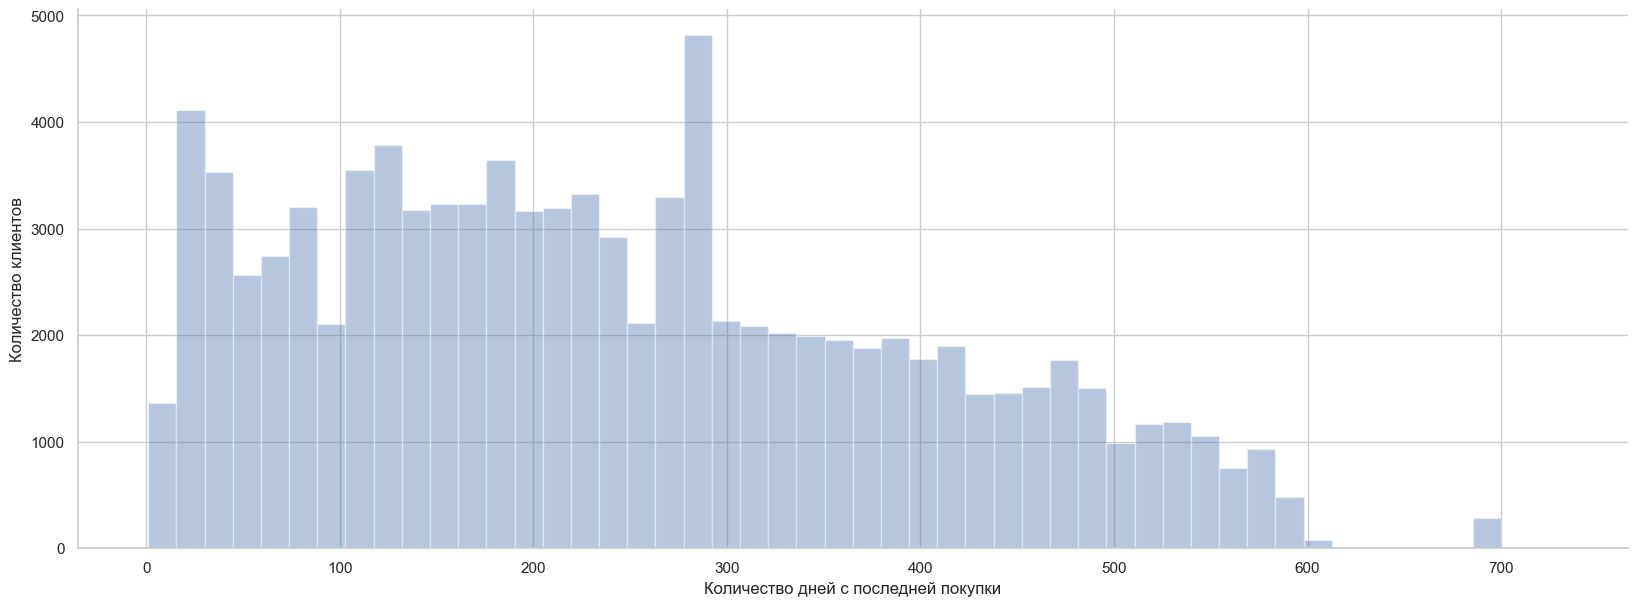

In [524]:
sns.distplot(custom_ord_item_RFM.Recency, kde=False)
plt.xlabel('Количество дней с последней покупки')
plt.ylabel('Количество клиентов')
sns.despine()

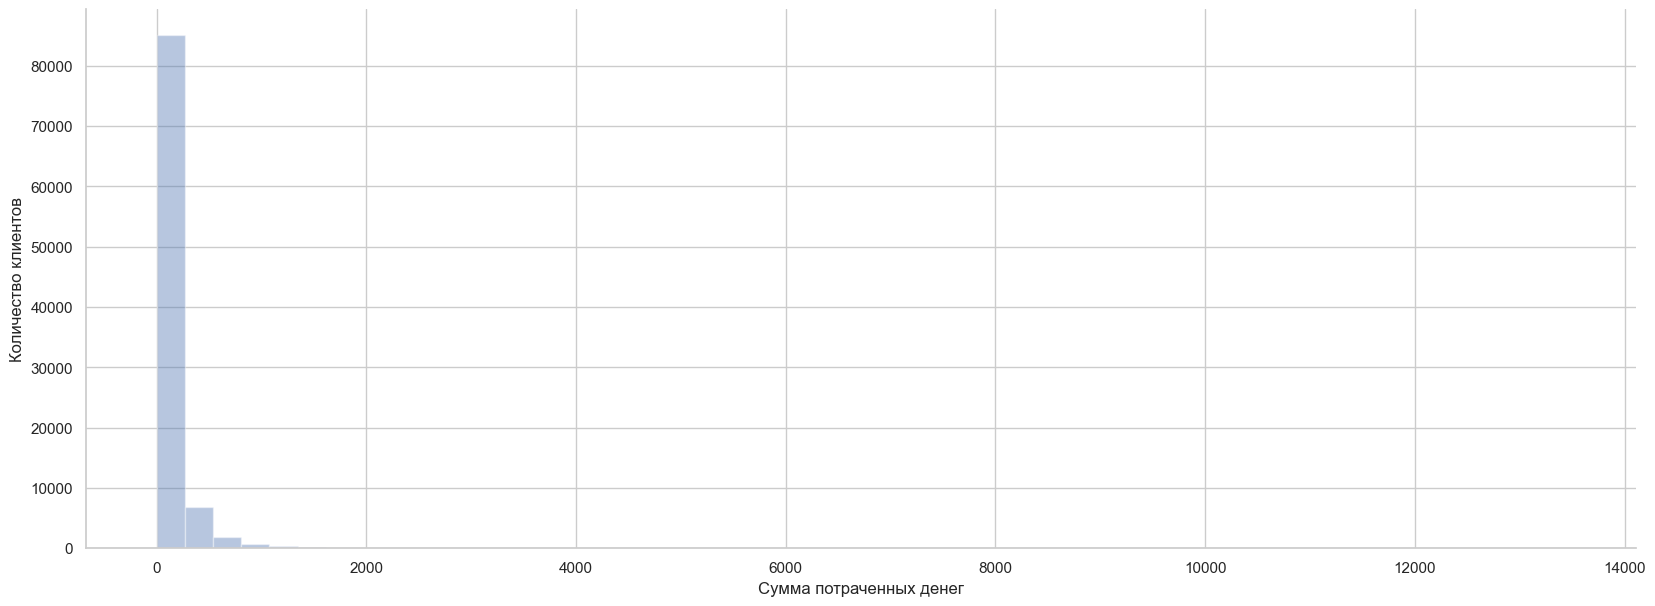

In [525]:
sns.distplot(custom_ord_item_RFM.Monetary, kde=False)
plt.xlabel('Сумма потраченных денег')
plt.ylabel('Количество клиентов')
sns.despine()

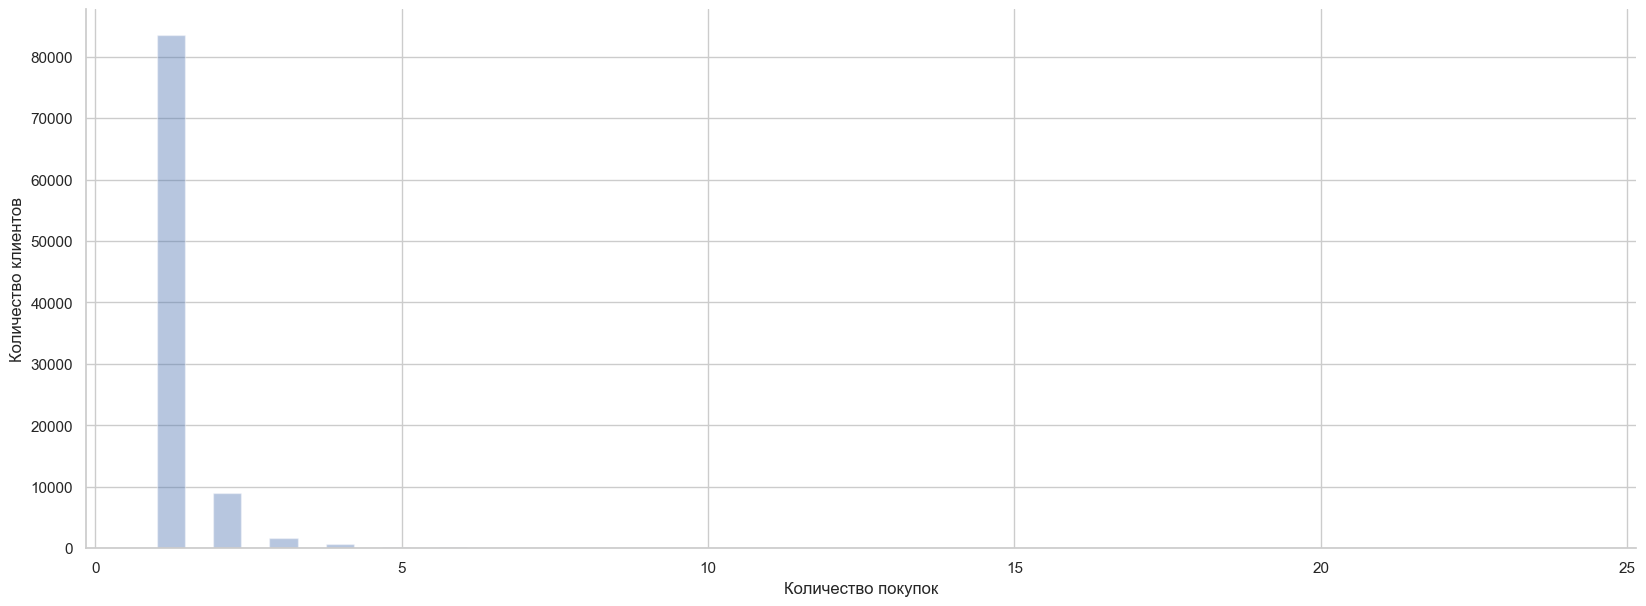

In [526]:
sns.distplot(custom_ord_item_RFM.Frequency, kde=False)
plt.xlabel('Количество покупок')
plt.ylabel('Количество клиентов')
sns.despine()

In [533]:
#Дополнительно проверю "Frequency"
count_customer = custom_ord_item_RFM \
.query('Frequency>5') \
.agg({'customer_unique_id':'count'})
count_data = len(custom_ord_item_RFM)
percent_regular_customer = (count_customer/count_data)*100
percent_regular_customer

customer_unique_id    0.330119
dtype: float64

In [532]:
custom_ord_item_RFM.Frequency.value_counts()

1     83551
2      8996
3      1672
4       632
5       254
6       198
7        46
8        16
11       11
9        11
10       11
12        9
14        3
15        2
13        2
20        2
16        1
18        1
21        1
24        1
Name: Frequency, dtype: int64

### Я вижу что большая часть клиентов совершили меньше 5 покупок. Так же большая часть клиентов потратили денег до 2000. При сегментировании каждого параметра на 5 частей, получится 125 сегментов, часть из которых учитывая данные будут близки между собой. Исходя из этого буду делить данные не на пять сегментов а на три, что даст 27 сегментов.

Судя по результату "Recency" и "Monetary" можно разделить на сегменты по квантилям, а "Frequency" исходя из того что 75й персантиль равен минимальному значению, разделю на сегменты следующим образом: 1, 2-5, больше 5

In [540]:
# Создам словарь с разделением по квантилям столбцов "R", "M" и разделением колонки "F" с шагом 5

RM_seg = custom_ord_item_RFM. iloc [:, [1,3]].quantile(q=[0.33, 0.66]).to_dict()
F_seg = {'Frequency': {0.33: 2, 0.66: 5}}

In [541]:
RM_seg

{'Recency': {0.33: 153.0, 0.66: 292.0}, 'Monetary': {0.33: 57.99, 0.66: 125.0}}

In [542]:
F_seg

{'Frequency': {0.33: 2, 0.66: 5}}

In [543]:
#Напишу функцию для разделения на сегменты по квантилям используя созданный словарь

def split (a,b,c):
    if a <= c[b][0.33]:
        return 1
    elif a <= c[b][0.66]:
        return 2
    else:
        return 3

In [544]:
#Добавлю новые столбцы с сегментами с помощью функций

custom_ord_item_RFM['R'] = custom_ord_item_RFM['Recency'].apply(split, args=('Recency', RM_seg,))
custom_ord_item_RFM['F'] = custom_ord_item_RFM['Frequency'].apply(split, args=('Frequency', F_seg,))
custom_ord_item_RFM['M'] = custom_ord_item_RFM['Monetary'].apply(split, args=('Monetary', RM_seg,))

In [545]:
custom_ord_item_RFM.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM_Score
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,1,1,3,113
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,1,1,1,111
2,0000f46a3911fa3c0805444483337064,542,1,69.00,3,1,2,112
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,3,1,1,111
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,3,1,3,113


In [548]:
custom_ord_item_RFM.sort_values('Recency', ascending=True)

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM_Score
95083,ff22e30958c13ffe219db7d711e8f564,1,2,290.00,1,1,3,113
67518,b4dcade04bc548b7e3b0243c801f8c26,5,1,99.00,1,1,2,112
45599,7a22d14aa3c3599238509ddca4b93b01,5,1,63.90,1,1,2,112
1538,0421e7a23f21e5d54efed456aedbc513,5,1,109.90,1,1,2,112
13741,24ac2b4327e25baf39f2119e4228976a,5,1,84.99,1,1,2,112
...,...,...,...,...,...,...,...,...
17750,2f64e403852e6893ae37485d5fcacdaf,700,1,21.90,3,1,1,111
5480,0eb1ee9dba87f5b36b4613a65074337c,701,1,100.00,3,1,2,112
48972,830d5b7aaa3b6f1e9ad63703bec97d23,718,3,134.97,3,2,3,123
27050,4854e9b3feff728c13ee5fc7d1547e92,729,1,59.50,3,1,2,112


In [529]:
#Объеденю значения в оценку RFM, 
custom_ord_item_RFM['RFM_Score'] = custom_ord_item_RFM['R'].map(str) + \
                                   custom_ord_item_RFM['F'].map(str) + \
                                   custom_ord_item_RFM['M'].map(str)

In [554]:
custom_ord_item_RFM.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM_Score
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,1,1,3,113
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,1,1,1,111
2,0000f46a3911fa3c0805444483337064,542,1,69.00,3,1,2,112
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,3,1,1,111
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,3,1,3,113


In [511]:
#Сегментов должно быть 27 (3 в кубе), проверю на всякий случай
custom_ord_item_RFM.RFM_Score.nunique()

27

In [551]:
custom_ord_item_RFM['Recency'].quantile(q=[0.33, 0.66])

0.33    153.0
0.66    292.0
Name: Recency, dtype: float64

In [553]:
custom_ord_item_RFM['Frequency'].quantile(q=[0.33, 0.66])

0.33    1.0
0.66    1.0
Name: Frequency, dtype: float64

In [555]:
custom_ord_item_RFM['Monetary'].quantile(q=[0.33, 0.66])

0.33     57.99
0.66    125.00
Name: Monetary, dtype: float64

### Итого их действительно 27. Значения у колонки RFM_Score следующие:

Первая цифра - показатель Recency “давности” покупок (1 - покупал недавно менее 154 дней назад, 2 - покупал относительно недавно(154 - 292 дня назад) , 3 - покупал давно(Более 292 дней назад)

Вторая цифра - показатель Frequency “частоты” покупок (3 - покупал часто(больше 5-х раз), 2 - покупал менее часто (от 2 до 5 раз), 1 - покупал редко(1 раз))

Третья цифра - показатель Monetary “прибыльности клиента” (3 - больше всего денег (более 125 "денег" (валюта не указана) , 2 - принес среднее количество денег (58 - 125 "денег"), 1 - принёс мало денег(менее 58 "денег"))

In [561]:
#Добавлю поле с названием группы в зависимости от совокупности сегментов

segt_map = {
    r'11[1-3]': 'New customers',
    r'121': 'New customers',
    r'12[2-3]': 'Potential loyalists',
    r'13[1-2]': 'Best',
    r'133': 'Champion',
    r'21[1-3]': 'Hibernating',
    r'221': 'Hibernating',
    r'22[2-3]': 'Hibernating potential',
    r'23[1-3]': 'Hibernating potential',
    r'31[1-3]': 'Lost',
    r'221': 'Lost',
    r'32[2-3]': 'Lost loyalists',
    r'33[1-3]': 'Can’t Lose Them'

}

custom_ord_item_RFM['Segment'] = custom_ord_item_RFM['R'].map(str) +  custom_ord_item_RFM['F'].map(str) + custom_ord_item_RFM['F'].map(str)
custom_ord_item_RFM['Segment'] = custom_ord_item_RFM['Segment'].replace(segt_map, regex=True)
custom_ord_item_RFM.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM_Score,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,1,1,3,113,New customers
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,1,1,1,111,New customers
2,0000f46a3911fa3c0805444483337064,542,1,69.00,3,1,2,112,Lost
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,3,1,1,111,Lost
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,3,1,3,113,Lost


### Добавлю график для лучшего понимания распределения сегментов

In [626]:
rfm_graph = custom_ord_item_RFM \
                 .groupby('Segment', as_index=False) \
                 .agg({'customer_unique_id': 'count'}) \
                 .rename(columns={'customer_unique_id': 'count_customers'})\
                 .sort_values('count_customers', ascending=False)
rfm_graph.head()

,Segment,count_customers
4,Lost,31423
6,New customers,30667
2,Hibernating,30457
3,Hibernating potential,948
7,Potential loyalists,868


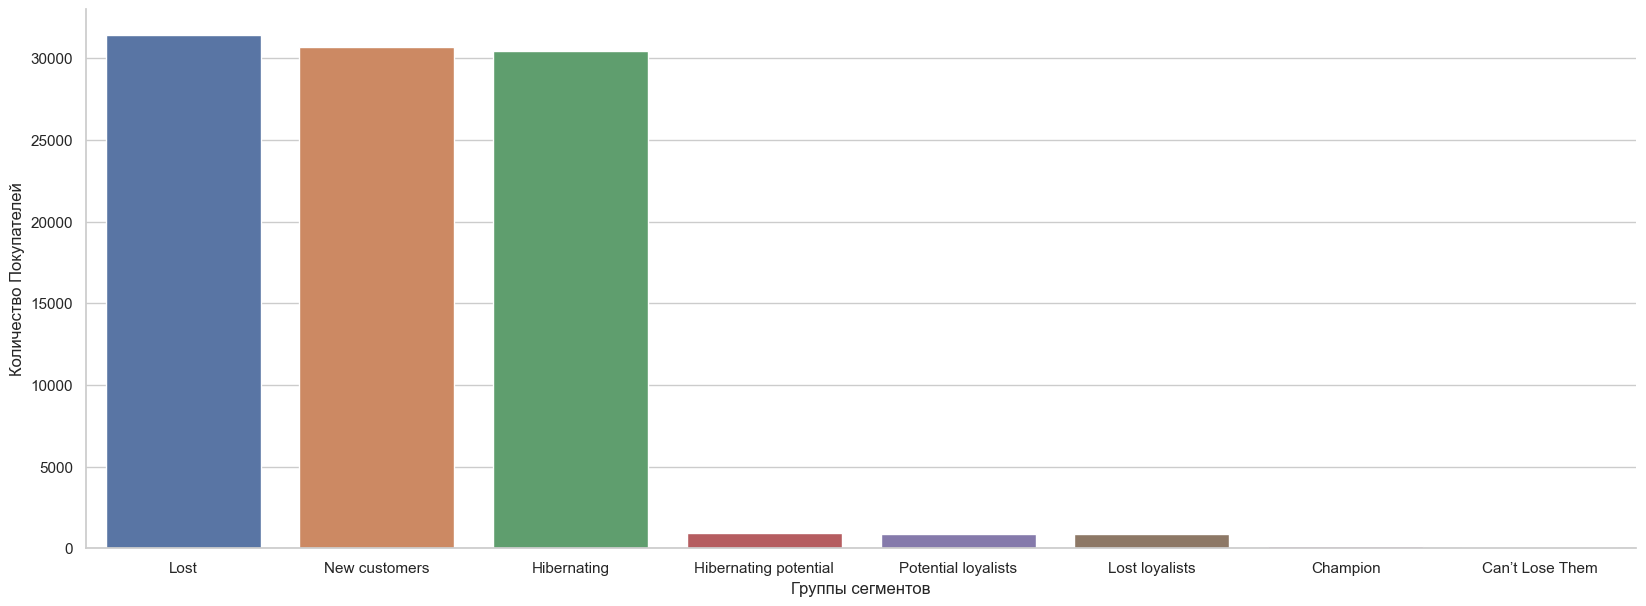

In [627]:
sns.barplot(data=rfm_graph, x='Segment', y='count_customers')
plt.xlabel('Группы сегментов')
plt.ylabel('Количество Покупателей')
sns.despine()

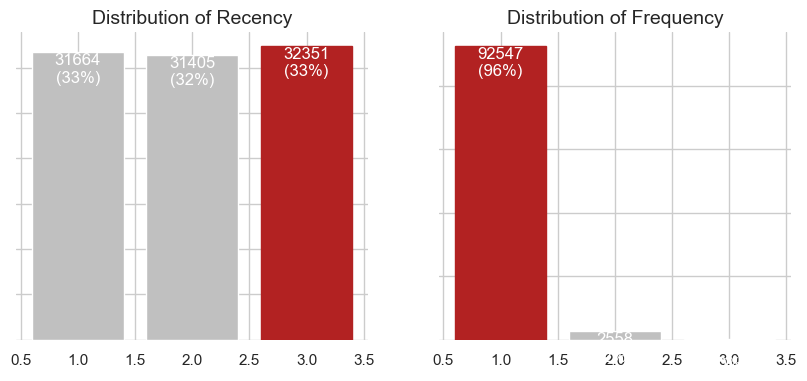

In [579]:
# plot the distribution of customers over R and F
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

for i, p in enumerate(['R', 'F']):
    parameters = {'R':'Recency', 'F':'Frequency'}
    y = custom_ord_item_RFM[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Distribution of {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')

plt.show()

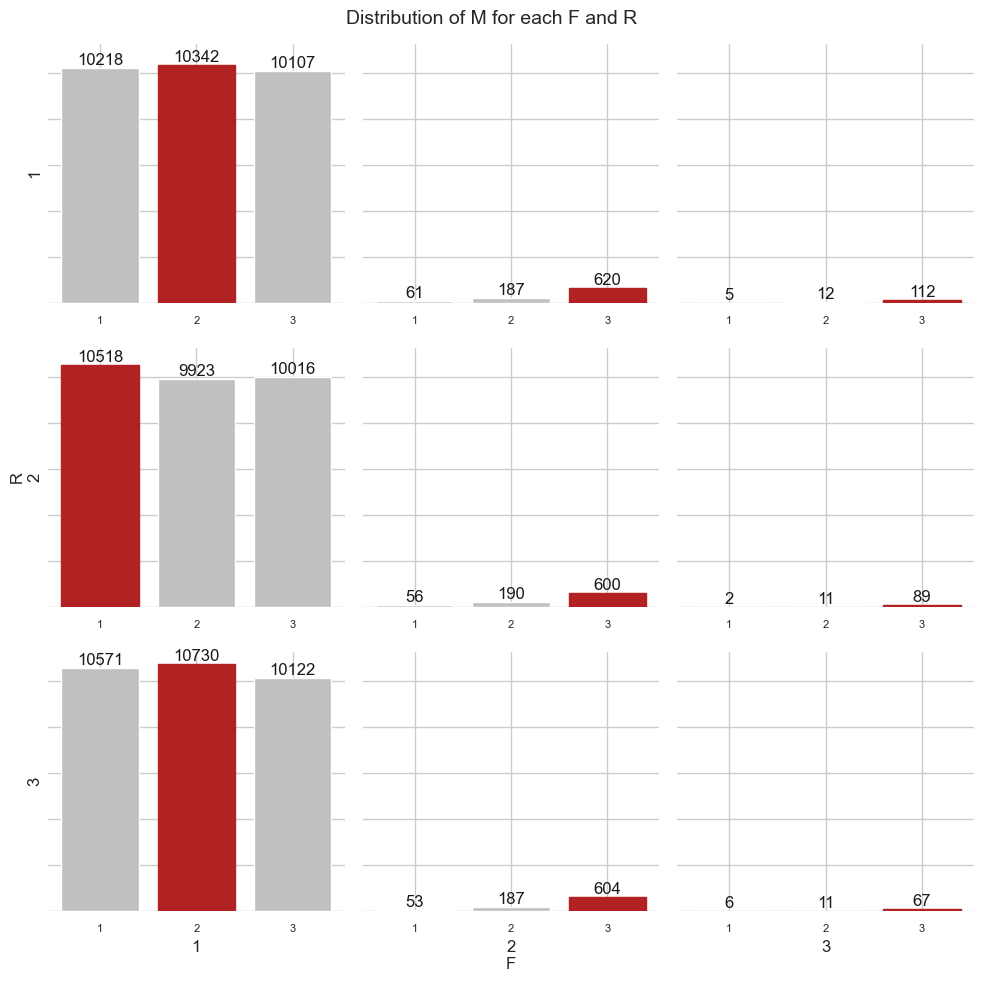

In [582]:
# plot the distribution of M for RF score
fig, axes = plt.subplots(nrows=3, ncols=3,
                         sharex=False, sharey=True,
                         figsize=(10, 10))

r_range = range(1, 4)
f_range = range(1, 4)
for r in r_range:
    for f in f_range:
        y = custom_ord_item_RFM[(custom_ord_item_RFM['R'] == r) & (custom_ord_item_RFM['F'] == f)]['M'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='silver')
        if r == 3:
            if f == 2:
                ax.set_xlabel('{}\nF'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 2:
                ax.set_ylabel('R\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('firebrick')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
fig.suptitle('Distribution of M for each F and R',
             fontsize=14)
plt.tight_layout()
plt.show()

#### Не очень показательные графики, построю ещё один

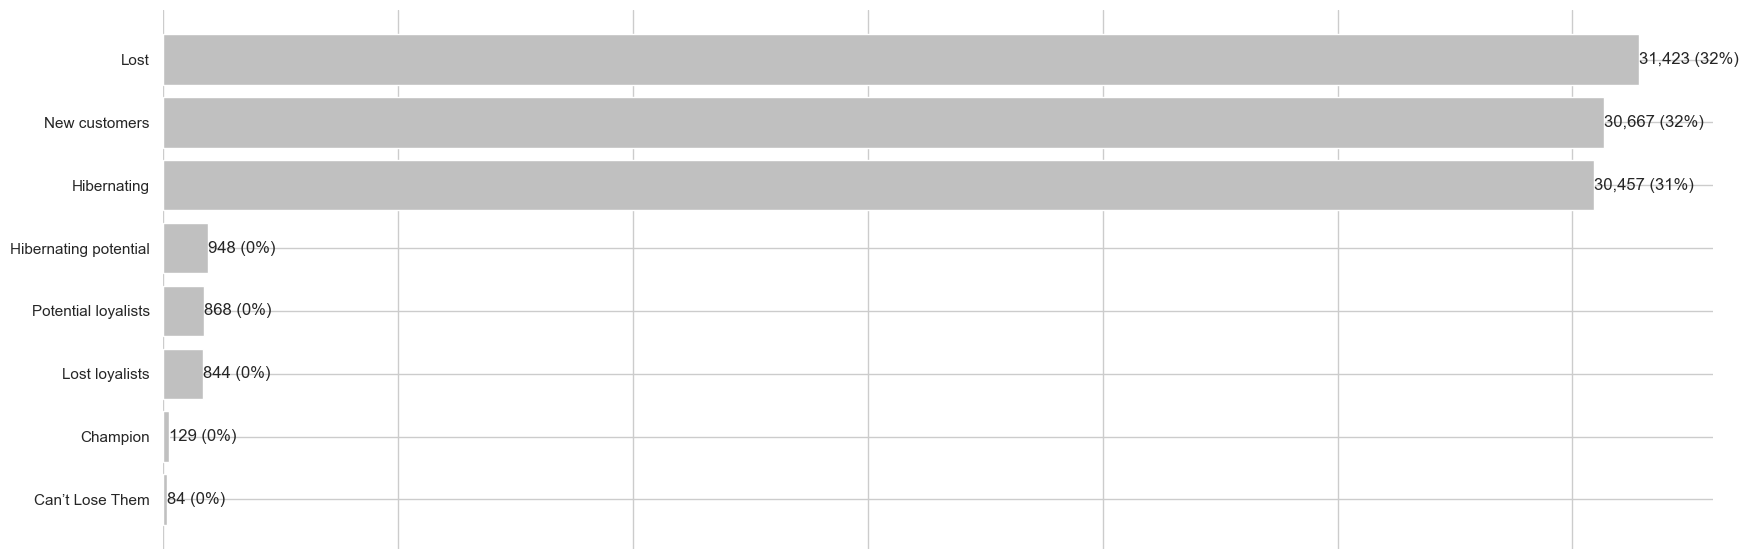

In [658]:
# Посчитаю количество клиентов в каждом сегменте 

segments_counts = custom_ord_item_RFM['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['champions', 'loyal customers']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

### Посчитаю дополнительную информайцию по данным группам - количество клиентов в каждой, сумму денег, количество продаваемых едениц товаров (группа с меньшей денежной массой но с ощутимой товарной суммой может потенциально привести к росту прибыли если работать со средним чеком покупки)

In [617]:
custom_ord_item_RFM \
.groupby('Segment', as_index=False) \
.agg({'customer_unique_id':'count'}) \
.sort_values('customer_unique_id', ascending=False)

,Segment,customer_unique_id
4,Lost,31423
6,New customers,30667
2,Hibernating,30457
3,Hibernating potential,948
7,Potential loyalists,868
5,Lost loyalists,844
1,Champion,129
0,Can’t Lose Them,84


In [619]:
custom_ord_item_RFM \
.groupby('Segment', as_index=False) \
.agg({'Monetary':'sum'}) \
.sort_values('Monetary', ascending=False)

,Segment,Monetary
4,Lost,4371182.18
6,New customers,4288932.87
2,Hibernating,4020136.33
3,Hibernating potential,276323.72
7,Potential loyalists,258508.82
5,Lost loyalists,253480.13
1,Champion,72643.90
0,Can’t Lose Them,50435.75


In [628]:
custom_ord_item_RFM \
.groupby('Segment', as_index=False) \
.agg({'Frequency':'sum'}) \
.sort_values('Frequency', ascending=False)

,Segment,Frequency
4,Lost,34424
6,New customers,33689
2,Hibernating,33430
3,Hibernating potential,3658
7,Potential loyalists,2996
5,Lost loyalists,2921
1,Champion,933
0,Can’t Lose Them,599


## Всю информацию стоит передать продакт-менеджеру Василию. По данными таблицам самая финансово и количественно прибыльная группа клиентов - потеряннные клиенты, давно переставшие совершать покупки. Вторая по размеру группа - клиенты, бывшие выгодными и совершавшие покупки регулярно, но по какой-то причине прекратившие это делать. С данными группами клиентов необходимо предпринимать меры по возвращению, потенциально можно увеличить прибыль в 3 раза 